In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import os
from sklearn.preprocessing import scale

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [2]:
!pip install -q pybithumb

     |████████████████████████████████| 103 kB 9.2 MB/s 
     |████████████████████████████████| 60 kB 8.5 MB/s 
     |████████████████████████████████| 251 kB 30.0 MB/s 


In [3]:
import pybithumb

In [4]:
mydf = pybithumb.get_ohlcv('BTC', interval='day')

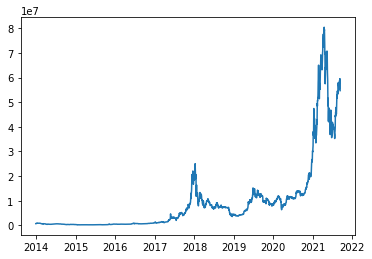

In [5]:
plt.plot(mydf['open'])

In [7]:
mydf['open'] = scale(mydf['open']).tolist()
mydf['high'] = scale(mydf['high']).tolist()
mydf['low'] = scale(mydf['low']).tolist()
mydf['close'] = scale(mydf['close']).tolist()
mydf['volume'] = scale(mydf['volume']).tolist()

In [9]:
device = torch.device("cuda:0") # GPU 사용
target_n = 1 # 맞춰야하는 품목/품종의 수
learning_rate = 5e-4 # 학습률
BATCH_SIZE = 128 # 배치사이즈
EPOCHS = 50 # 총 eopochs
teacher_forcing = False # 교사강요 설정
n_layers = 3 # rnn레이어 층
dropout = 0.2 # 드롭아웃
window_size = 28 # 인코더 시퀀스 길이
future_size = 28 # 디코더 시퀀스 길이
hidden_dim = 128 # rnn 히든차원
save_path = '.'

In [10]:
x_data = []
y_data = []
for i in range(mydf.shape[0]-window_size-future_size):
    x = mydf.iloc[i:i+window_size, 0:].to_numpy()
    y = mydf.iloc[i+window_size:i+window_size+future_size, 3::2].to_numpy()
    y_0 = np.zeros([1, y.shape[1]]) # 디코더 첫 입력값 추가
    x_data.append(x)
    y_data.append(np.concatenate([y_0, y], axis=0))
x_data = np.array(x_data)
y_data = np.array(y_data)

In [11]:
class CustomDataset(Dataset):
    def __init__(self, encoder_input, decoder_input):
        self.encoder_input = encoder_input
        self.decoder_input = decoder_input
        
    def __len__(self):
        return len(self.encoder_input)
    
    def __getitem__(self, i):
        return {
            'encoder_input' : torch.tensor(self.encoder_input[i], dtype=torch.float32),
            'decoder_input' : torch.tensor(self.decoder_input[i], dtype=torch.float32)
        }

In [23]:
train_test_split = 30
x_train = x_data[:-train_test_split-future_size]
y_train = y_data[:-train_test_split-future_size]
x_val = x_data[-train_test_split:]
y_val = y_data[-train_test_split:]

In [24]:
train_dataset = CustomDataset(x_train, y_train)
val_dataset = CustomDataset(x_val, y_val)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=2, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=2, shuffle=False)

In [25]:
sample_batch = next(iter(train_dataloader))

In [26]:
sample_batch['encoder_input'].shape, sample_batch['decoder_input'].shape

(torch.Size([128, 28, 5]), torch.Size([128, 29, 1]))

In [27]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers, dropout):
        super().__init__()
        self.n_layers = n_layers
        
        self.rnn = nn.GRU(input_dim, hidden_dim, n_layers, dropout=dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inp_seq):
        inp_seq = inp_seq.permute(1,0,2).contiguous()
        outputs, hidden = self.rnn(inp_seq)
        
        return outputs, hidden

In [28]:
class BahdanauAttention(nn.Module):
    def __init__(self, dec_output_dim, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = nn.Linear(dec_output_dim, units)
        self.W2 = nn.Linear(dec_output_dim, units)
        self.V = nn.Linear(dec_output_dim, 1)

    def forward(self, hidden, enc_output):
        query_with_time_axis = hidden.unsqueeze(1)
        
        score = self.V(torch.tanh(self.W1(query_with_time_axis) + self.W2(enc_output)))
        
        attention_weights = torch.softmax(score, axis=1)
        
        context_vector = attention_weights * enc_output
        context_vector = torch.sum(context_vector, dim=1)

        return context_vector, attention_weights

In [29]:
class Decoder(nn.Module):
    def __init__(self, dec_feature_size, encoder_hidden_dim, output_dim, decoder_hidden_dim, n_layers, dropout, attention):
        super().__init__()
        self.output_dim = output_dim
        self.decoder_hidden_dim = decoder_hidden_dim
        self.n_layers = n_layers
        self.attention = attention
        
        self.layer = nn.Linear(dec_feature_size, encoder_hidden_dim)
        self.rnn = nn.GRU(encoder_hidden_dim*2, decoder_hidden_dim, n_layers, dropout=dropout)
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, enc_output, dec_input, hidden):
        dec_input = self.layer(dec_input)
        context_vector, attention_weights = self.attention(hidden, enc_output)
        dec_input = torch.cat([torch.sum(context_vector, dim=0), dec_input], dim=1)
        dec_input = dec_input.unsqueeze(0)
        
        output, hidden = self.rnn(dec_input, hidden)

        prediction = self.fc_out(output.sum(0))
        
        return prediction, hidden

In [30]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, attention):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, encoder_input, decoder_input, teacher_forcing=False):
        batch_size = decoder_input.size(0)
        trg_len = decoder_input.size(1)
        
        outputs = torch.zeros(batch_size, trg_len-1, self.decoder.output_dim).to(device)
        enc_output, hidden = self.encoder(encoder_input)
        
        dec_input = decoder_input[:, 0]
        for t in range(1, trg_len):
            output, hidden = self.decoder(enc_output, dec_input, hidden)
            outputs[:, t-1] = output
            if teacher_forcing == True:
                dec_input = decoder_input[:, t]
            else:
                dec_input = output
        
        return outputs

In [31]:
encoder = Encoder(input_dim=x_data.shape[-1], hidden_dim=hidden_dim, n_layers=n_layers, dropout=dropout)
attention = BahdanauAttention(dec_output_dim=hidden_dim, units=hidden_dim)
decoder = Decoder(
    dec_feature_size=target_n, encoder_hidden_dim=hidden_dim, output_dim=target_n,
    decoder_hidden_dim=hidden_dim, n_layers=n_layers, dropout=dropout,
    attention = attention
)

model = Seq2Seq(encoder, decoder, attention)
model = model.to(device)

In [35]:
def my_custom_metric(pred, true):
  
    score = torch.mean(torch.abs((true-pred))/(true))
    
    return score

In [36]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.L1Loss()
score_fn = my_custom_metric

In [37]:
def train_step(batch_item, epoch, batch, training, teacher_forcing):
    encoder_input = batch_item['encoder_input'].to(device)
    decoder_input = batch_item['decoder_input'].to(device)
    if training is True:
        model.train()
        optimizer.zero_grad()
        output = model(encoder_input, decoder_input, teacher_forcing)
        loss = criterion(output, decoder_input[:,1:])
        score = score_fn(output, decoder_input[:,1:])
        loss.backward()
        optimizer.step()
        
        return loss, score
    else:
        model.eval()
        with torch.no_grad():
            output = model(encoder_input, decoder_input, False)
            loss = criterion(output, decoder_input[:,1:])
            score = score_fn(output, decoder_input[:,1:])
        return loss, score

In [38]:
loss_plot, val_loss_plot = [], []
score_plot, val_score_plot = [], []

for epoch in range(EPOCHS):
    total_loss, total_val_loss = 0, 0
    total_score, total_val_score = 0, 0
    
    training = True
    with tqdm(train_dataloader,
              total = train_dataloader.__len__(),
              unit="batch") as tqdm_dataset:
        for batch, batch_item in enumerate(tqdm_dataset):
            batch_loss, batch_score = train_step(batch_item, epoch, batch, training, teacher_forcing)
            total_loss += batch_loss
            total_score += batch_score
            
            tqdm_dataset.set_postfix({
                'Epoch': epoch + 1,
                'Loss': '{:06f}'.format(batch_loss.item()),
                'Total Loss' : '{:06f}'.format(total_loss/(batch+1)),
                'Score': '{:06f}'.format(batch_score.item()),
                'Total Score' : '{:06f}'.format(total_score/(batch+1)),
            })
    loss_plot.append(total_loss/(batch+1))
    score_plot.append(total_score/(batch+1))
    
    training = False
    with tqdm(val_dataloader,
              total = val_dataloader.__len__(),
              unit="batch") as tqdm_dataset:
        for batch, batch_item in enumerate(tqdm_dataset):
            batch_loss, batch_val_score = train_step(batch_item, epoch, batch, training, teacher_forcing)
            total_val_loss += batch_loss
            total_val_score += batch_val_score
            
            tqdm_dataset.set_postfix({
                'Epoch': epoch + 1,
                'Val Loss': '{:06f}'.format(batch_loss.item()),
                'Total Val Loss' : '{:06f}'.format(total_val_loss/(batch+1)),
                'Val Score': '{:06f}'.format(batch_val_score.item()),
                'Total Val Score' : '{:06f}'.format(total_val_score/(batch+1)),
            })
    val_loss_plot.append(total_val_loss/(batch+1))
    val_score_plot.append(total_val_score/(batch+1))

100%|██████████| 1/1 [00:00<00:00,  6.01batch/s, Epoch=50, Val Loss=0.586808, Total Val Loss=0.586808, Val Score=0.223349, Total Val Score=0.223349]


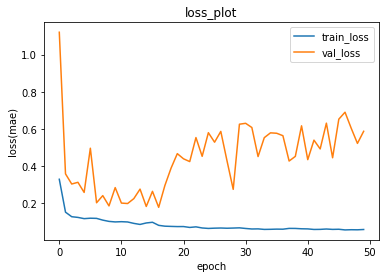

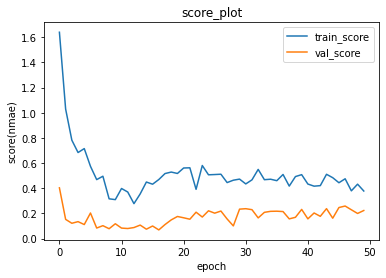

In [40]:
plt.plot(loss_plot, label='train_loss')
plt.plot(val_loss_plot, label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss(mae)')
plt.title('loss_plot')
plt.legend()
plt.show()

plt.plot(score_plot, label='train_score')
plt.plot(val_score_plot, label='val_score')
plt.xlabel('epoch')
plt.ylabel('score(nmae)')
plt.title('score_plot')
plt.legend()
plt.show()